# Temperature Vs. Probability of Failure

If the job of the data scientist is to create a model, the job of the data engineer is to put a model into production. Here we illustrate both steps using the Python API.

First, we create a sample data set. The 'x' axis represents the average temperature of an engine over the past two hours, and the y axis reprents the probability that the engine will fail in the next 30 minutes.

<IPython.core.display.Javascript object>


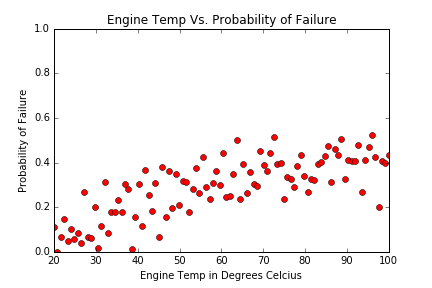

In [1]:
%matplotlib inline
%matplotlib notebook

import numpy as np, math
import matplotlib.pyplot as plt

# Create sample dataset
xvalues = np.linspace(20,100, 100)
yvalues = np.array([((np.cos((x-50)/100)*100 + np.sin(x/100)*100 + np.random.normal(0, 13, 1)[0])/150.0) for x in xvalues])
ymin = np.amin(yvalues)
yvalues = [y - ymin for y in yvalues]

# Plot dataset
fig0, ax0 = plt.subplots()
plt.title("Engine Temp Vs. Probability of Failure")
plt.ylabel("Probability of Failure")
plt.xlabel("Engine Temp in Degrees Celcius")
ax0.set_xlim(20, 100)
ax0.set_ylim(0, 1)
ax0.plot(xvalues,
        yvalues, "ro", linewidth = 2, color = 'red', label = 'target')



# Build a Model to Fit The Data

We want to create a model which takes a temperature, and provides an approximate probability of failure. Here, we use a library called PyBrain which trains a feed forward neural net (FFN) to predict failure probability. If you don't have PyBrain installed, install it using this command (the default pip repo won't work):

    pip install git+https://github.com/pybrain/pybrain.git

When you run this cell, you can see the model improving itself iteratively. The blue line is the model's fit.

<IPython.core.display.Javascript object>


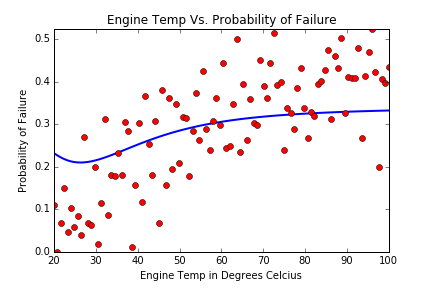

In [2]:
%matplotlib inline
%matplotlib notebook

#----------
# build the dataset
#----------
from pybrain.datasets import SupervisedDataSet
import numpy as np, math
from nn_utils import train_nn

ds = SupervisedDataSet(1, 1)
for x, y in zip(xvalues, yvalues):
    ds.addSample((x,), (y,))

#----------
# build the network
#----------
net = train_nn(xvalues, yvalues, rate=0.0001, layers = [100,100,100], batch=False, magnification=0.0, iterations = 50)
    

# Use Model In Realtime Streaming Application

In the above cell, we trained a model to predict failure given a temperature reading. This model is represented as a Python object `net`. Using the streamsx.topology Python API, we can insert that model into a realtime streaming application such as the following.

In the next cell, we create random temperature readings `xdata_raw`, and use them as source tuples in our streaming application. Each tuple will be passed into and processed by the `neural_net_model` class, which produces the probability reading. Since we run this application with the `JUPYTER` context, it is run in a single process on the current host, and the output is returned as the stdout stream of a process, which can be consumed to retrieve the data and graph it in jupyter.

For information on how to retrieve data from a remote host, review the `ViewDemo`, `MultiGraph`, and `python_rest_example` notebooks.

<IPython.core.display.Javascript object>


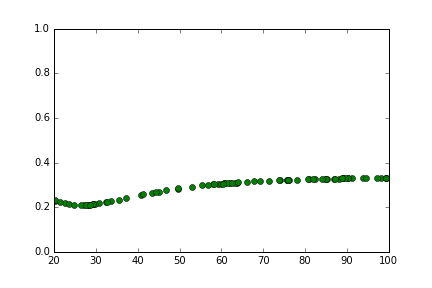

Nov 17, 2016 12:54:43 AM com.ibm.streamsx.topology.internal.streams.InvokeMakeToolkit invoke
INFO: Invoking spl-make-toolkit
Nov 17, 2016 12:54:44 AM com.ibm.streamsx.topology.internal.streams.InvokeMakeToolkit invoke
INFO: /opt/ibm/InfoSphere_Streams/4.2.0.0/bin/spl-make-toolkit --make-operator -i /home/streamsadmin/git/streamsx.topology/samples/python/topology/notebooks/NetDemo/tk8559290221128914682
Nov 17, 2016 12:54:45 AM com.ibm.streamsx.topology.internal.streams.InvokeMakeToolkit invoke
INFO: spl-make-toolkit complete: return code=0
Nov 17, 2016 12:54:45 AM com.ibm.streamsx.topology.internal.streams.InvokeSc getToolkitPath
INFO: ToolkitPath:/home/streamsadmin/git/streamsx.topology/com.ibm.streamsx.topology:/opt/ibm/InfoSphere_Streams/4.2.0.0/toolkits
Nov 17, 2016 12:54:45 AM com.ibm.streamsx.topology.internal.streams.InvokeSc invoke
INFO: Invoking SPL compiler (sc) for main composite: myTop::myTop
Nov 17, 2016 12:54:45 AM com.ibm.streamsx.topology.internal.streams.InvokeSc invoke

IndexError: list index out of range

In [3]:
from streamsx.topology.topology import Topology
from my_module import neural_net_model
from streamsx.topology import context
from jupyter_utilities import get_next_line, graph_from_outstream
import time, sys
import matplotlib.pyplot as plt
import random
import logging

# Define test data
xdata_raw = [random.uniform(0,100) for x in range(100)]

# Define operator
nnm = neural_net_model(net)

# Build Graph
top = Topology("myTop")
stream_ = top.source(xdata_raw)
stream_.transform(nnm).print()
# Submit
out = context.submit("JUPYTER", top.graph, log_level=logging.DEBUG)
graph_from_outstream(out, xdata_raw, 20, 100, 0, 1)